# How Have the Concepts in “MoneyBall" (Sabremetrics) Changed Player Valuations and Produced Wins per Dollar in Major League Baseball (MLB)?

In 2003, Michael  Lewis published “MoneyBall: The Art of Winning an Unfair Game”.  It chronicled the efforts of Oakland Athletics’ General Manager Billy Beane to determine if there were previously unknown measures of a player’s value to a team rather than the obvious Batting Average (BA) and Fielding Percentage (FP) measurements.  Beane theorized that a team’s payroll could be far more effectively utilized by paying less money for these heretofore unrecognized and undervalued skills.  Prior to Beane’s tenure as GM of the Oakland As, team ownership dictated drastic cuts in payroll due to years of high payroll and losing records.  Beane had to win with less resources.  His teams had great success from 2000-2003 with one of the lowest team payrolls in the league.  The following analysis attempts to determine the extent to which Beane’s theories have proven true.

# Description of Dataset:

www.fangraph.com has compiled data from MLB since 1871 to the present.  The extensive collection includes statistics organized by league, team, players and position.  In addition to expected data items such as, games won/lost, batting averages, ERA (earned run average),  FP,  and player salaries,  more recently invented statistical measures such as UZR (Utility Zone Rating) and OBP (On Base Percentage) have been included since their invention and collection.  Upon payment of a monthly or annual subscription, the interface below is used to generate reports which can be exported into CSV files.

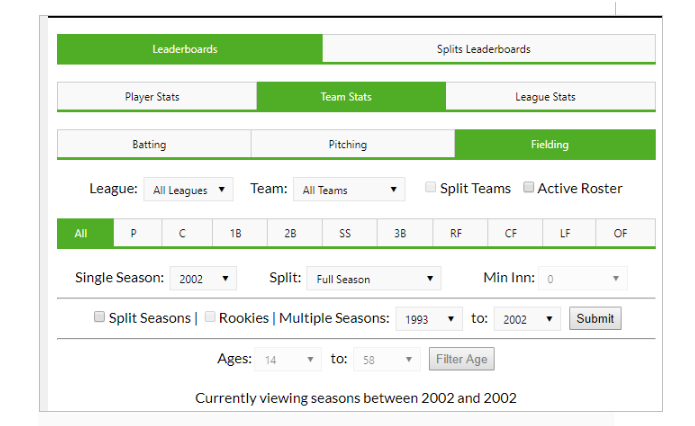

In order to obtain a single dataset required for this analysis a broad dump of 58 columns for all 147 years was required comprising 573 KB of data.


# Analytic Questions

Is it true that winning teams have been able to do so with lower payrolls because previously unrecognized and undervalued skills are now being considered?  i.e. Has the correlation between team payroll and wins changed from before MoneyBall to five years later?

Is it true that focusing on factors other than hitting, i.e. fielding, have produced more Wins/Season?

Is it true that a focus on On Base Percentage (OBP) is more valuable then Batting Average (BA), evidenced by a higher correlation of wins to OBP rather than BA since the MoneyBall concepts were published?

Has a focus on skills other than hitting caused any fielding (by position) to receive more focus and improve?


# Further Research

How does data trend for periods further out then five years?   

Solution:  Obtain data from further out then presently available.


Will UZR (Ultimate Zone Rating) and OBP prove to be better indicators of ‘wins’ value than Fielding Percentage (FP) or BA?  UZR was invented with the concepts in Moneyball, and was not collected prior to 2003.  It is thought to be a better analysis of fielding ability than FP. Recreation of UZR data prior to 2003 might show if a focus on it is warranted and beneficial, in terms of wins.  A similar comparison of OBP v. Batting Average could be made as well.

Solution:  Construct/obtain UZR & OBP data from prior to       the MoneyBall era to compare to later years.

Has an emphasis on non-traditional measures such as UZR and OBP produced higher or salaries for players who have not had high Batting Averages?

Solution: Determine which, if any positions have become more valuable since MoneyBall in terms of wins, and ascertain if those positions know command greater salaries (adjusted for inflation).

Have the theories of Moneyball caused a shift in payroll that raises overall payrolls because now other players now earn more and the former obvious superstars still earn large salaries?

Solution:  Analyze the percentage of salaries by position and OBP to determine if they have grown since MoneyBall.

# Data and Conclusions

A. In 2002, the correlation between team payroll and wins was fairly strong.
 
B. 2002 data reveal a consistent correlation between Fielding Percentage and Wins per season.

C. OBP data contradicts MoneyBall theories that it should be more valued.

D. UZR data reveals a marked improvement in fielding skills from the center field and third base positions.  Shortstop skills have also significantly improved since MoneyBall.

# Note on appearance of plots

In an attmept to smooth the jagged nature of the plots, plotting the means of common outcomes grouped by x values was attempted.  The data was found to have none if any common x values, so the size of the plot was enlarged instead.


In [35]:
"""
Created on Mon Jan 21 11:53:44 2019

@author: Jack Sonntag

Plots MLB data in an attmept to gauge the impact of 2003's "Money Ball" on 
baseball, specifically, Payroll v. Wins, Wins v. Fielding %, Wins v. OBP (
On Base Percentage), and changes in positional UZR (Ultimate Zone Rating).

To determine if "Money Ball" has had an impact on the game, data from 5 years 
prior to it's publication is compared to data five yearas after.

"""
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

INFLATION_FACTOR = 1.168   # Apply to 2002 salary data to equalize with 2008 data to adjust for inflation, 
#                            accroding to the Morgan Freeman Money Calculator at 
#                            https://westegg.com/inflation/infl.cgi

In [36]:
# read data and drop empty rows
fields = ['year','wins','payroll','fp','obp']
data_path = 'all bball data.csv'
df = pd.read_csv(data_path, skipinitialspace=True, usecols=fields).dropna()
df.dropna(axis=1, inplace=True)
print(df.head())
print( df.describe())

plt.rcParams["figure.figsize"] = [10,8 ] # enlarge plot size

      year  wins      obp     fp     payroll
1506  2000    87  0.41079  0.981  92338260.0
1507  2006    83  0.39075  0.984  35417967.0
1618  2000    79  0.36516  0.980  19872000.0
1619  2000    91  0.41584  0.978  31971333.0
1620  2000    69  0.36908  0.981  62765129.0
             year        wins         obp          fp       payroll
count   330.00000  330.000000  330.000000  330.000000  3.300000e+02
mean   2005.00000   80.957576    0.378723    0.982891  7.548137e+07
std       3.16708   11.609058    0.020671    0.002700  3.287703e+07
min    2000.00000   43.000000    0.315030    0.976000  1.499850e+07
25%    2002.00000   72.000000    0.363750    0.981000  5.345838e+07
50%    2005.00000   82.000000    0.378880    0.983000  7.138510e+07
75%    2008.00000   90.000000    0.392528    0.985000  9.274165e+07
max    2010.00000  116.000000    0.437430    0.989000  2.083068e+08


2002 - correlation of Payroll to Wins % ->0.4424
2008 - correlation of Payroll to Wins % ->-0.0088


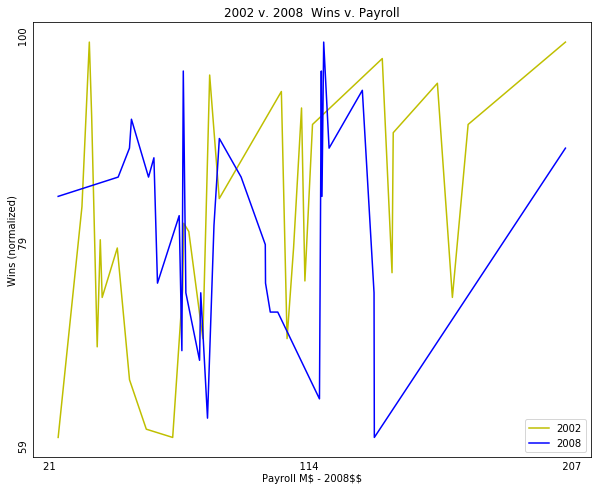

Suggesting importance of Payroll to Wins has reversed. Moneyball affirming.




In [37]:
def do_payroll(year, df):
    """
    do the payroll v. wins  comparision 
    
    input: year and dataframe
    output: plots, correlation observation 
    """
    yr_label = '2008'
    yr_color = 'b'
    wins = df.loc[df['year'] == int(year)]['wins']
    salary = df.loc[df['year'] == int(year)]['payroll']
    if (year == '2002'):
        salary = salary*INFLATION_FACTOR  #adjust for inflation
        yr_label = '2002'
        yr_color = 'y'
        
    salary_df= pd.DataFrame()
    salary_df['wins'] = minmax_scale(wins) #normalize data
    salary_df['payroll'] = minmax_scale(salary)
       
    # following section sets up x and y axis' to display sensible labels based on
    # actual data rather than normalized data
    hi_salary = int(salary.max()/1000000) 
    lo_salary = int(salary.min()/1000000)
    hi_wins = int(wins.max())
    lo_wins = int(wins.min())
    
    plt.xticks([])  #negate old ticks & build new x,y axis & title
    plt.yticks([])                
    yspaces = "                                                             "
    ylab =  "Wins (normalized)\n" + str(lo_wins) + yspaces + str(int((lo_wins+hi_wins)/2)) + yspaces + str(hi_wins)
    plt.ylabel(ylab)
    xspaces = "                                                                              "
    xlab = str(lo_salary) + xspaces + str(int((lo_salary+hi_salary)/2)) + xspaces + str(hi_salary) + "\nPayroll M$ - 2008$$"
    plt.xlabel(xlab)
    

    #plot data
    salary_df.sort_values("payroll", inplace=True)
    y=salary_df['wins']
    x=salary_df['payroll']
    plt.plot(x,y,color=yr_color,label=yr_label)
    title_str = ("2002 v. 2008  Wins v. Payroll")
    plt.title(title_str)
    plt.legend()
    print(year ,"- correlation of Payroll to Wins % ->{:.4f}".format(salary_df['payroll'].corr(salary_df['wins']) ))

do_payroll("2002", df)   #process 2002 data
do_payroll("2008", df)   #process 2008 data
plt.show()
print("Suggesting importance of Payroll to Wins has reversed. Moneyball affirming.\n\n")


2002 - correlation of OBP to Wins ->0.7745
2008 - correlation of OBP to Wins ->0.5211


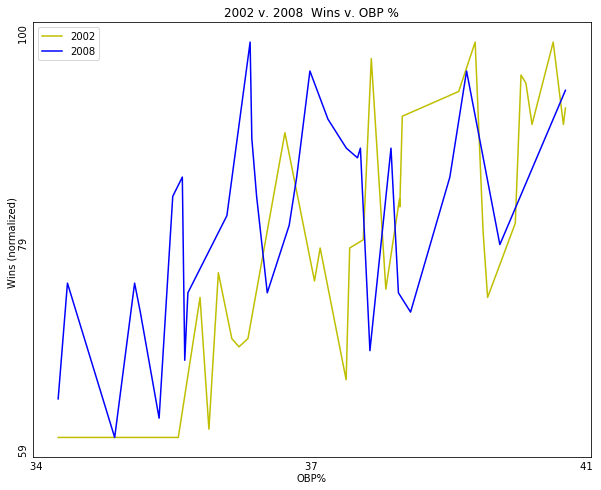

Suggesting OBP has become less important to winning. Moneyball contradictory.


In [38]:
def do_OBP(year, df):
    """ do Wins v. OBP comparison
          input: year and dataframe
          output: plots, correlation observation """

    yr_label = '2008'
    yr_color = 'b'
    if (year == '2002'):
        yr_label = '2002'
        yr_color = 'y'
        
    wins = df.loc[df['year'] == int(year)]['wins']
    obp = df.loc[df['year'] == int(year)]['obp']
       
    fp_df= pd.DataFrame()
    fp_df['wins'] = minmax_scale(wins) #normalize data
    fp_df['obp'] = minmax_scale(obp)
       
    # following section sets up x and y axis' to display sensible labels based on
    # actual data rather than normalized data
    hi_obp = int( (obp.max()*100))
    lo_obp = int( (obp.min()*100))
    hi_wins = int(wins.max())
    lo_wins = int(wins.min())
    plt.xticks([])  #negate old ticks & build new x,y axis & title
    plt.yticks([])
    yspaces = "                                                              "
    ylab = "Wins (normalized) \n" + str(lo_wins) + yspaces + str(int((lo_wins+hi_wins)/2)) + yspaces + str(hi_wins) 
    plt.ylabel(ylab)
    xspaces = "                                                                                    "
    xlab = str(lo_obp) + xspaces + str(int((lo_obp+hi_obp)/2)) + xspaces + str(hi_obp) + "\nOBP%"
    plt.xlabel(xlab)

    title_str = ("2002 v. 2008  Wins v. OBP %")
    plt.title(title_str)
    #fp_df.sort_values("obp", inplace=True)
    fp_df.sort_values("obp", inplace=True)
    y=fp_df['wins']
    x=fp_df['obp']
    plt.plot(x,y,color=yr_color,label=yr_label)
    plt.title(title_str)
    plt.legend()
    print(year ,"- correlation of OBP to Wins ->{:.4f}".          format(fp_df['obp'].corr(fp_df['wins']) ))
do_OBP("2002", df)
do_OBP("2008", df)
plt.show()
print("Suggesting OBP has become less important to winning. Moneyball contradictory.") 


2002 - correlation of FP% to Wins ->0.4742
2008 - correlation of FP% to Wins ->0.3234


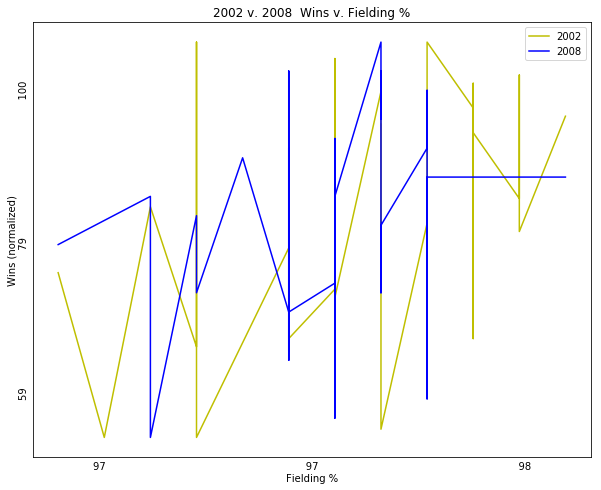

Suggesting FP has become less important to winning. Moneyball contradictory.




In [39]:
def do_fielding(year, df):
    """  do the wins v. Fielding % comparison
          input: year and dataframe
          output: plots, correlation observation 
    """
    yr_label = '2008'
    yr_color = 'b'
    if (year == '2002'):
        yr_label = '2002'
        yr_color = 'y'
    
    wins = df.loc[df['year'] == int(year)]['wins']
    fp = df.loc[df['year'] == int(year)]['fp']
       
    fp_df= pd.DataFrame()
    fp_df['wins'] = minmax_scale(wins) #normalize data
    fp_df['fp'] = minmax_scale(fp)
       
    # following section sets up x and y axis' to display sensible labels based on
    # actual data rather than normalized data
    hi_fp = int( (fp.max()*100))
    lo_fp = int( (fp.min()*100))
    hi_wins = int(wins.max())
    lo_wins = int(wins.min())
    plt.xticks([])  #negate old ticks & build new x,y axis & title
    plt.yticks([])
    yspaces = "                                            "
    ylab = "Wins (normalized)\n" + str(lo_wins) + yspaces + str(int((lo_wins+hi_wins)/2)) + yspaces + str(hi_wins) 
    plt.ylabel(ylab)
    xspaces = "                                                                "
    xlab =str(lo_fp) + xspaces + str(int((lo_fp+hi_fp)/2)) + xspaces + str(hi_fp) +  "\nFielding %"
    plt.xlabel(xlab)

#    title = " Wins v. Fielding % Green=2002, Yellow=2008"
    title_str = ("2002 v. 2008  Wins v. Fielding %")
    fp_df.sort_values("fp", inplace=True)
    y=fp_df['wins']#.sort_values()
    x=fp_df['fp']#.sort_values()
    plt.plot(x,y,color=yr_color,label=yr_label)
    title_str = ("2002 v. 2008  Wins v. Fielding %")
    plt.title(title_str)
    plt.legend()
    print(year ,"- correlation of FP% to Wins ->{:.4f}".          format(fp_df['fp'].corr(fp_df['wins']) ))

do_fielding("2002", df)
do_fielding("2008", df)
plt.show()
print("Suggesting FP has become less important to winning. Moneyball contradictory.\n\n")


# UZR comparison
Illustrate whether 'Moneyball' has had an impact on defensive factors such as UZR.


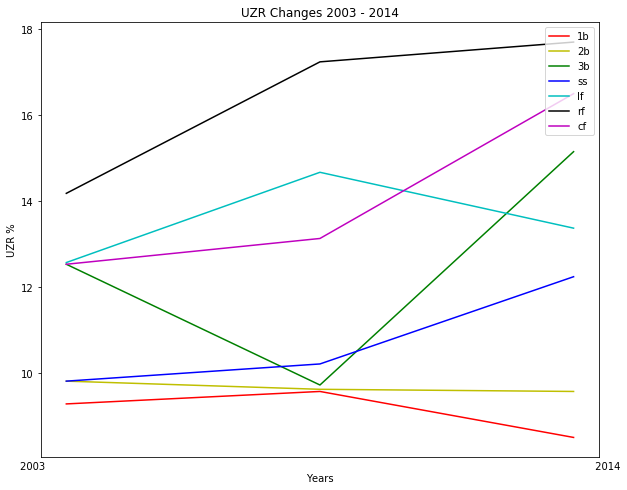

Since the publication of Moneyball and the implemation of UZR as a tool:

The 3b (3rd base), cf (center field) and ss (shortstop) posistions appear to have taken on greater importance.
The lf (left field) & 1b (1st base) appear to have taken on lesser importance.


In [40]:

plt.ylabel("UZR %")
plt.yticks([6.0,8.0,10.0,12.0,14.0,16.0,18.0])
plt.title("UZR Changes 2003 - 2014")

data = pd.read_csv('UZR data.csv')
df = pd.DataFrame(data)
plt.plot(df['1b'],color='r',label="1b")
plt.plot(df['2b'],color='y',label="2b")
plt.plot(df['3b'],color='g',label="3b")
plt.plot(df['ss'],color='b',label="ss")
plt.plot(df['lf'],color='c',label="lf")
plt.plot(df['rf'],color='k',label="rf")
plt.plot(df['cf'],color='m',label="cf")
plt.legend(loc="upper right")

plt.xticks([]) 
spaces = "                                                                                        "
xlbl = "2003"  + 2*spaces + "2014\nYears"
plt.xlabel(xlbl)
plt.show()
print( "Since the publication of Moneyball and the implemation of UZR as a tool:\n")
print("The 3b (3rd base), cf (center field) and ss (shortstop) posistions appear to have taken on greater importance.")
print( "The lf (left field) & 1b (1st base) appear to have taken on lesser importance.")

# Conclusions -  Comparing 2002 to 2008:

1. The relationship between payroll and wins has lessened. Affirming Moneyball theories.
2. The relationship between OBP and wins has lessened. Contradicting Moneyball theories.
3. The relationship between Fielding % and wins has lessened. Contradicting Moneyball theories.
4. Five of eight fielding positions have changed their importance.  No direct correlation to Wins, but when taken in conjuction with the lessend importance of Fielding % suggests, UZR is a better tool than FP.

# Glossary

FP - Fielding Percentage - a measure that reflects the percentage of times a defensive player properly handles
     a batted or thrown ball. It is calculated by the sum of putouts and assists, divided by the number of
     total chances (putouts + assists + errors).

OBP - On Base Percentage - a measure of how often a batter reaches base. It is approximately equal to 
      Times on Base/Plate appearances. The full formula is OBP = (Hits + Walks + Hit by Pitch) / (At Bats + 
      Walks + Hit by Pitch + Sacrifice Flies).

UZR - Utility Zone Rating - compares the event that actually happened (hit/out/error) to data on similarly 
      hit balls in the past to determine how much better or worse the fielder did than the "average" player. 
      UZR divides a baseball field into multiple zones and assigns individual fielders responsibility for 
      those zones. It is a more precise measure of a fielder's ability than FP.